In [22]:
from ipynb.fs.full._init_ import *
os.getcwd()
#df = pd.read_csv('criteo-uplift-v2.csv', sep = ',',low_memory = False, header = 0)
#print(df.shape)

'/Users/diegoolaya/OneDrive - Vrije Universiteit Brussel/Criteo'

## Model elements

In [23]:
"""
I select a subset of the full Criteo dataset
"""
folds = load("folds.sav")
df = folds[1][0]
df = df.reset_index(drop=True)
"""
Treatment:
"""
T = 'exposure'
"""
Outcome:
"""
Y = 'visit'
df[Y] = df[Y].astype('category')
"""
Predictors:
"""
nonpredictors = [T,Y,'treatment','conversion']
X = [variable for variable in list(df.columns) if variable not in nonpredictors] 

In [15]:
"""
Descriptive
"""
desc_table = pd.crosstab(index = df[Y], columns = df[T], margins = False)
print(desc_table)
print("Total number of observations =",df.shape[0])
print("Total number of variables = ",len(X))
print("Number of control group observations = ",df[T].value_counts()[0])
print("Number of treatment group observations = ",df[T].value_counts()[1])
print("Visit rate treatment = ",desc_table[1][1]/(desc_table[1][1] + desc_table[1][0]))
print("Visit rate control = ",desc_table[0][1]/(desc_table[0][1] + desc_table[0][0]))
print("Overall effect = ",desc_table[1][1]/(desc_table[1][1] + desc_table[1][0])-desc_table[0][1]/(desc_table[0][1] + desc_table[0][0]))

exposure      0    1
visit               
0         10893  208
1           399  147
Total number of observations = 11647
Total number of variables =  12
Number of control group observations =  11292
Number of treatment group observations =  355
Visit rate treatment =  0.4140845070422535
Visit rate control =  0.035334750265674814
Overall effect =  0.37874975677657874


## CV

In [24]:
"""
5 folds stratified CV
"""
Amount_folds = 5
#dump(folds,'folds.sav')
# CV
folds = create_folds(df,Amount_folds,T,Y,X)   

## Causal model

In [30]:
"""
3 causal models: CF,T_learner,S_learner
"""
random_state = 100
model_names = ['CF','T_learner','S_learner']
#xgb.XGBClassifier(objective = "binary:logistic",gamma = 1,max_depth = 10, subsample = 0.5,n_estimators = 500, random_state = random_state) 
#xgb.XGBClassifier(objective = "binary:logistic",n_estimators = 100, random_state = random_state)
#LogisticRegression(solver='saga',max_iter=3000, random_state = random_state)
#RandomForestClassifier(n_estimators = 100, random_state=random_state)
#AdaBoostClassifier(n_estimators=100,random_state=random_state)
from sklearn.ensemble import AdaBoostClassifier
algorithm_1 = LogisticRegression(solver='saga',max_iter=3000, random_state = random_state)
algorithm_2 = LogisticRegression(solver='saga',max_iter=3000, random_state = random_state)
algorithm_3 = LogisticRegression(solver='saga',max_iter=3000, random_state = random_state)
algorithm_4 = LogisticRegression(solver='saga',max_iter=3000, random_state = random_state)
####################################################

effect_estimates = []
for model in model_names:
    effect_estimates.append(fit_causal(folds,T,Y,X,model,algorithm_1,algorithm_2,algorithm_3,algorithm_4))
"""
Save estimates:
"""
#dump(effect_estimates,'effect_estimates_RF.sav')

/Users/diegoolaya/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/diegoolaya/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/diegoolaya/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/diegoolaya/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/diegoolaya/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: Conver

'\nSave estimates:\n'

## Performance

In [79]:
import statistics 
"""
There is two algoritms:
> LR: call "effect_estimates_LR.sav"
> XGB: call "effect_estimates_XGB.sav"
"""
effect_estimates= load("effect_estimates_XGB.sav")
"""
and three causal models (CF,T_learner,S_learner) where:
> CF = effect_estimates[0]
> T_learner = effect_estimates[1]
> S_learner = effect_estimates[2]

"""
model_predictions = effect_estimates[1]

"""
The OB and TC matrices
"""
def create_OB(b_11,b_10,b_01,b_00):
    OB = [[b_00,b_01],[b_10,b_11]]
    return OB;

def create_TC(c_11,c_10,c_01,c_00):
    TC = [[c_00,c_01],[c_10,c_11]]
    return TC;

"""
Specify the b and c parameters:
"""
#b = [10,100,200]
b = [100]
#benefit = 10
#c_pro = [0.2,0.3,0.4]
c = 0.1

av_qini_insensitive = []
av_qini_sensitive = []
std_qini_insensitive = []
std_qini_sensitive = []
av_profit_insensitive = []
av_profit_sensitive = []
std_profit_insensitive = []
std_profit_sensitive = []
max_profit_sensitive = []
max_profit_insensitive = []
MP_sen_index = []
MP_sen_val = []
MP_in_index = []
MP_in_val = []

for benefit in b:
    
    """
    Equal benefits
    """
    benefit_pos = benefit
    benefit_neg = benefit*1.2
    cost_pos = benefit_pos*c
    cost_neg = benefit_pos*c
    
    """
    OB and TC matrices
    """
    OB = create_OB(benefit_pos,benefit_neg,0,0)
    TC = create_TC(cost_pos,0,cost_neg,0)
    #TC = create_TC(benefit_pos*c,0,benefit_pos*c,0)
    
    """
    Gamma and delta:
    """
    gamma = (OB[0][0] - TC[0][0] - OB[0][1] + TC[0][1])/(OB[1][0] - TC[1][0] - OB[0][0] + TC[0][0])
    delta = (OB[1][0] - TC[1][0] + OB[0][1] - TC[0][1] - OB[1][1] + TC[1][1] - OB[0][0] + TC[0][0])/(OB[1][0] - TC[1][0] - OB[0][0] + TC[0][0])

    qini_sensitive = []
    qini_insensitive = []
    profit_sensitive = []
    profit_insensitive = []
    list_sen_prof = []
    list_ins_prof = []
    for fold in list(range(len(model_predictions))):
        """
        Qini
        """
        perf_table_sensitive = performance_profit(model_predictions,gamma,delta,True,"qini","Profit-sensitive")
        perf_table_insensitive = performance_profit(model_predictions,gamma,delta,False,"qini","Profit-insensitive")
        qini_sensitive.append(qini_metric(perf_table_sensitive[fold]))
        qini_insensitive.append(qini_metric(perf_table_insensitive[fold]))
        """
        Profit
        """
        prof_table_sensitive = performance_profit(model_predictions,gamma,delta,True,"Profit","Profit-sensitive")
        prof_table_insensitive = performance_profit(model_predictions,gamma,delta,False,"Profit","Profit-insensitive")
        """
        Average profit:
        """
        profit_sensitive.append(prof_table_sensitive[fold].iloc[:,1].mean())
        profit_insensitive.append(prof_table_insensitive[fold].iloc[:,1].mean())
        """
        Max. profit and fractions
        """
        list_sen_prof.append(prof_table_sensitive[fold].iloc[:,1])
        list_ins_prof.append(prof_table_insensitive[fold].iloc[:,1])
        
    max_profit_sensitive = pd.concat(list_sen_prof, axis = 1)
    max_profit_sensitive['mean'] = max_profit_sensitive.mean(axis=1)
    MP_sen_index.append(max_profit_sensitive['mean'].idxmax())
    MP_sen_val.append(max(max_profit_sensitive['mean']))

    max_profit_insensitive = pd.concat(list_ins_prof, axis = 1)
    max_profit_insensitive['mean'] = max_profit_insensitive.mean(axis=1)
    MP_in_index.append(max_profit_insensitive['mean'].idxmax())
    MP_in_val.append(max(max_profit_insensitive['mean']))
        
    # Qini results
    av_qini_insensitive.append(statistics.mean(qini_insensitive))
    av_qini_sensitive.append(statistics.mean(qini_sensitive))
    std_qini_insensitive.append(statistics.stdev(qini_insensitive))
    std_qini_sensitive.append(statistics.stdev(qini_sensitive))
    
    # Profit results
    av_profit_insensitive.append(statistics.mean(profit_insensitive))
    av_profit_sensitive.append(statistics.mean(profit_sensitive))
    std_profit_insensitive.append(statistics.stdev(profit_insensitive))
    std_profit_sensitive.append(statistics.stdev(profit_sensitive))
    
print("Qini_in: ",av_qini_insensitive) 
print("Qini_sen: ",av_qini_sensitive)
#print(std_qini_insensitive)
#print(std_qini_sensitive)
print("Prof_in: ",av_profit_insensitive) 
print("Prof_se: ",av_profit_sensitive)
#print(std_profit_insensitive)
#print(std_profit_sensitive)
print("MP_in_val: ",MP_in_val)
print("MP_sen_val: ",MP_sen_val)
print("MP_in_index: ",MP_in_index)
print("MP_sen_index: ",MP_sen_index)

Qini_in:  [0.016582729484934448]
Qini_sen:  [0.004396318572934621]
Prof_in:  [16.214943914893297]
Prof_se:  [14.680068484894866]
MP_in_val:  [27.166945349010113]
MP_sen_val:  [27.166945349010113]
MP_in_index:  [100]
MP_sen_index:  [100]


### Plot

#### Qini

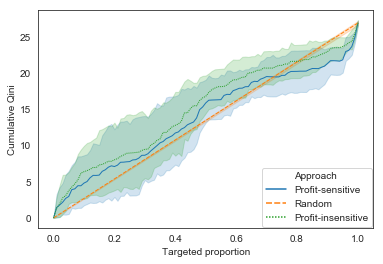

In [80]:
"""
Plot the Qini curves
"""
performance_to_plot_sensitive = performance_profit(model_predictions,gamma,delta,True,"qini","Profit-sensitive")
performance_to_plot_insensitive = performance_profit(model_predictions,gamma,delta,False,"qini","Profit-insensitive")
performance_to_plot_sensitive = pd.melt(pd.concat(performance_to_plot_sensitive), ['x'])
performance_to_plot_insensitive = pd.melt(pd.concat(performance_to_plot_insensitive),['x'])
performance_to_plot = pd.concat([performance_to_plot_sensitive,performance_to_plot_insensitive])
performance_to_plot.columns = ['x','Approach',"Value"]
sns.set_style("white")
ax = sns.lineplot(x='x', y= 'Value', hue='Approach', style = 'Approach',lw=1,data = performance_to_plot)
plt.xlabel("Targeted proportion")
plt.ylabel("Cumulative Qini")
#plt.xticks(np.linspace(0, 100, 11, endpoint = True))
#ax.legend(loc = 4, frameon = False, ncol = 1, labelspacing= 0.2)
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.legend(loc=4, borderaxespad=0.1)
#fig_uplift = ax.get_figure()
#fig_uplift.savefig('Qini_Criteo_second.pdf',bbox_inches='tight',transparent =True)

#### Profit

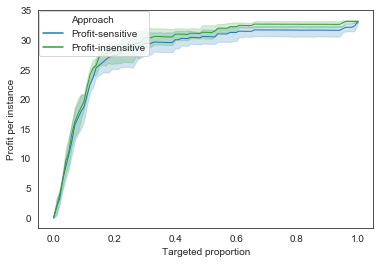

In [29]:
import statistics 
"""
Plot the profit curve
    > Specify algoritm: "effect_estimates_XGB.sav"
    > Specify causal model: effect_estimates[0]
"""

#effect_estimates= load("effect_estimates_LR.sav")
model_predictions = effect_estimates[2]

def create_OB(b_11,b_10,b_01,b_00):
    OB = [[b_00,b_01],[b_10,b_11]]
    return OB;

def create_TC(c_11,c_10,c_01,c_00):
    TC = [[c_00,c_01],[c_10,c_11]]
    return TC;

"""
Specify benefit and cost parameters
"""
benefit = 100
c = 0.1
benefit_pos = benefit
benefit_neg = benefit
    
OB = create_OB(benefit_pos,benefit_neg,0,0)
TC = create_TC(benefit_pos*c,0,(benefit_pos*c)*c,0)
#TC = create_TC(benefit_pos*c,0,benefit_pos*c,0)
    
gamma = (OB[0][0] - TC[0][0] - OB[0][1] + TC[0][1])/(OB[1][0] - TC[1][0] - OB[0][0] + TC[0][0])
delta = (OB[1][0] - TC[1][0] + OB[0][1] - TC[0][1] - OB[1][1] + TC[1][1] - OB[0][0] + TC[0][0])/(OB[1][0] - TC[1][0] - OB[0][0] + TC[0][0])

performance_to_plot_sensitive = performance_profit(model_predictions,gamma,delta,True,"profit","Profit-sensitive")
performance_to_plot_insensitive = performance_profit(model_predictions,gamma,delta,False,"profit","Profit-insensitive")
performance_to_plot_sensitive = pd.melt(pd.concat(performance_to_plot_sensitive), ['x'])
performance_to_plot_insensitive = pd.melt(pd.concat(performance_to_plot_insensitive),['x'])
performance_to_plot = pd.concat([performance_to_plot_sensitive,performance_to_plot_insensitive])
performance_to_plot.columns = ['x','Approach',"Value"]
sns.set_style("white")
flatui = ["#1f77b4", "#2ca02c"]
ax = sns.lineplot(x='x', y= 'Value', hue='Approach', palette=flatui,lw=1,data = performance_to_plot)
plt.xlabel("Targeted proportion")
plt.ylabel("Profit per instance")
#plt.xticks(np.linspace(0, 100, 11, endpoint = True))
#ax.legend(loc = 4, frameon = False, ncol = 1, labelspacing= 0.2)
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.legend(loc=2, borderaxespad=0.1)#loc = 4
#fig_uplift = ax.get_figure()
#fig_uplift.savefig('b10_CF_Criteo.pdf',bbox_inches='tight',transparent =True)

In [83]:
"""
Estimates the Qini and the profit
"""
def performance_profit(model_predictions,gamma,delta,frontier,metric,approach_name):
    
    """
    Lenght of the bins: here is 100 but can be any number
    """
    len_fold = []
    for fold in list(range(len(model_predictions))):
        len_fold.append(len(model_predictions[fold]))
    min_lenght_folds = min(len_fold)
    min_lenght_folds = 100
    
    """
    Obtain the performance table:
    """
    def performance_table(df,min_lenght_folds,frontier,metric,approach_name):
        if frontier == True:
            df['tau'] = gamma + delta*df['Prob_treat']
            df['target'] = np.where(df['s'] >= df['tau'],1,-1)
            #df['d'] = abs(delta*df.loc[:,'Prob_treat'] - df.loc[:,'s']+gamma)/(math.sqrt((delta**2)+1))#*df['target']
            df['d'] = (df.loc[:,'s'] - delta*df.loc[:,'Prob_treat'] - gamma)/(math.sqrt((delta**2)+1))
            df_sorted = df.sort_values(by = ["d"], ascending = False).reset_index(drop=True)
        else:
            df_sorted = df.sort_values(by = ["s"], ascending = False).reset_index(drop=True)
        
        df_sorted["ranking"] =  list(range(1,len(df_sorted)+1))
        labels = list(range(1,min_lenght_folds+1))
        df_sorted["bin"] = pd.cut(df_sorted['ranking'], len(labels), labels = labels).astype(int)
        df_sorted.index = df_sorted.index + 1
        df_sorted["ct"] = np.where(df_sorted[T]==0,1,0)
        df_sorted["y_tr"] = np.where((df_sorted[T]==1) & (df_sorted[Y]==1) ,1,0)
        df_sorted["y_ct"] = np.where((df_sorted[T]==0) & (df_sorted[Y]==1) ,1,0)
        n_t = df_sorted.pivot_table(index='bin', values= T, aggfunc='sum')
        n_c = df_sorted.pivot_table(index='bin', values= "ct", aggfunc='sum')
        n_y1_t = df_sorted.pivot_table(index='bin', values= 'y_tr', aggfunc='sum')
        n_y1_c = df_sorted.pivot_table(index='bin', values= "y_ct", aggfunc='sum')
        s_t = pd.concat([n_c,n_t,n_y1_c,n_y1_t], axis = 1)
        s_t.columns = ["n_c","n_t","n_y1_c","n_y1_t"]
        s_t["n_y0_t"] = s_t["n_t"] - s_t["n_y1_t"]
        s_t["n_y0_c"] = s_t["n_c"] - s_t["n_y1_c"]
        s_t["bin"] = s_t.index
        s_t["cumsum_n_t"] = s_t["n_t"].cumsum()
        s_t["cumsum_n_c"] = s_t["n_c"].cumsum()
        s_t["cumsum_n_y1_t"] = s_t["n_y1_t"].cumsum()
        s_t["cumsum_n_y1_c"] = s_t["n_y1_c"].cumsum()
        s_t["cumsum_n_y0_t"] = s_t["n_y0_t"].cumsum()
        s_t["cumsum_n_y0_c"] = s_t["n_y0_c"].cumsum()
        
        s_t["e11"] = s_t["cumsum_n_y1_t"]/s_t["cumsum_n_t"].iloc[-1]
        s_t["e10"] = s_t["cumsum_n_y1_c"]/s_t["cumsum_n_c"].iloc[-1]
        s_t["e01"] = s_t["cumsum_n_y0_t"]/s_t["cumsum_n_t"].iloc[-1]
        s_t["e00"] = s_t["cumsum_n_y0_c"]/s_t["cumsum_n_c"].iloc[-1]
        s_t["e11-e10"] = s_t["e11"] - s_t["e10"]
        
        """
        Calculate the Qini at each threshold
        """
        s_t["qini"] = s_t["cumsum_n_y1_t"] - (s_t["cumsum_n_y1_c"]*s_t["cumsum_n_t"])/s_t["cumsum_n_c"]
        s_t = s_t.replace(to_replace = np.nan, value = 0) 
        overall_inc_gains = s_t["qini"].iloc[-1]
        random_inc_gains = np.append([0],np.cumsum(np.repeat(overall_inc_gains / (s_t.loc[s_t.index[-1], "bin"]),(s_t.loc[s_t.index[-1], "bin"]))))
        
        """
        Calculate the profit at each threshold:
        """
        net_ben_T_1 = OB[1][1] - TC[1][1]
        net_ben_C_1 = OB[1][0] - TC[1][0]
        net_ben_T_0 = OB[0][1] - TC[0][1]
        net_ben_C_0 = OB[0][0] - TC[0][0]
        s_t['profit'] = s_t["e11"]*net_ben_T_1 - s_t["e10"]*net_ben_C_1 + s_t["e01"]*net_ben_T_0 - s_t["e00"]*net_ben_C_0
        #s_t['profit'] = s_t["e11-e10"]*OB[1][1] - s_t["e11"]*TC[1][1] - s_t["e01"]*TC[0][1]
        s_t = s_t.replace(to_replace = np.nan, value = 0) 

        # Qini
        qini = s_t["qini"]
        qini = pd.Series(qini).values
        qini = np.append([0],qini)

        # Profit
        profit = s_t['profit']
        profit = pd.Series(profit).values
        profit = np.append([0],profit)

        # X axis
        x = s_t["bin"]/(s_t.loc[s_t.index[-1], "bin"])
        x = pd.Series(x).values
        x = np.append([0],x)
        
        if metric == "qini":
            performance_table = pd.DataFrame(list(zip(x,qini, random_inc_gains)),columns =['x',approach_name, 'Random'])
        else:
            performance_table = pd.DataFrame(list(zip(x,profit)),columns =['x',approach_name])
            
            
        """
        Testing:
        """
        cum_nt = s_t["cumsum_n_y1_c"]
        cum_nt = pd.Series(cum_nt).values
        cum_nt = np.append([0],cum_nt)
        perf_testing = pd.DataFrame(list(zip(x,cum_nt)),columns =['x',approach_name])
        perf_testing[approach_name] = perf_testing[approach_name]/perf_testing[approach_name].iloc[-1]
        
        p11_ITEs = pd.concat([df[Y],df[T],df['Prob_treat'],df['s']], axis = 1)
        
        return perf_testing;
    
    performance_tables_fold = []
    for fold in list(range(len(model_predictions))):
        performance_tables_fold.append(performance_table(model_predictions[fold],min_lenght_folds,frontier,metric,approach_name))
    return performance_tables_fold;

"""
Calculate the qini metric (scalar value)
"""

def qini_metric(perf_object):
    x = list(perf_object.iloc[:,0]/100)
    y_inc = list(perf_object.iloc[:,1])
    y_ran = list(perf_object.iloc[:,2])
    
    def auc(x,y):
        auc = 0
        for i in list(range(1,len(x))):
            auc = auc + 0.5 * (x[i] - x[i-1]) * (y[i] + y[i-1])
        return auc
 
    auc_inc = auc(x,y_inc)
    auc_ran = auc(x,y_ran)
    
    qini = auc_inc - auc_ran
    
    return qini;

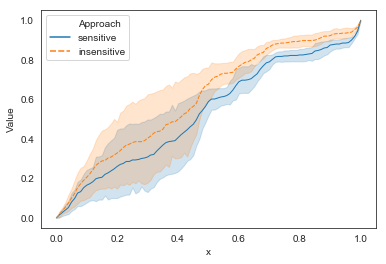

In [84]:
"""
Plots of cumulative positive instances in T and C
"""
performance_to_plot_sensitive = performance_profit(model_predictions,gamma,delta,True,"qini","sensitive")
performance_to_plot_insensitive = performance_profit(model_predictions,gamma,delta,False,"qini","insensitive")
performance_to_plot_sensitive = pd.melt(pd.concat(performance_to_plot_sensitive), ['x'])
performance_to_plot_insensitive = pd.melt(pd.concat(performance_to_plot_insensitive),['x'])
performance_to_plot = pd.concat([performance_to_plot_sensitive,performance_to_plot_insensitive])
performance_to_plot.columns = ['x','Approach',"Value"]
sns.set_style("white")
ax = sns.lineplot(x='x', y= 'Value', hue='Approach', style = 'Approach',lw=1,data = performance_to_plot)

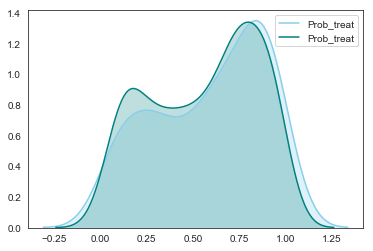

In [56]:
effect_estimates= load("effect_estimates_LR.sav")
model_predictions = effect_estimates[2]
"""
Distribution P11
"""
import seaborn as sns

perf_dist = performance_profit(model_predictions,gamma,delta,True,"profit","Profit-sensitive")
perf_dist = pd.concat(perf_dist, axis = 0)
perf_dist_t = perf_dist.loc[(perf_dist[T] == 1) & (perf_dist[Y] == 1)]
perf_dist_c = perf_dist.loc[(perf_dist[T] == 0) & (perf_dist[Y] == 1)]

sns.kdeplot( perf_dist_t["Prob_treat"] ,shade=True, color="skyblue")
sns.kdeplot( perf_dist_c["Prob_treat"] ,shade=True, color="teal")

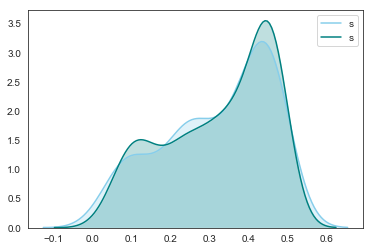

In [57]:
"""
Distribution ITE
"""
sns.kdeplot( perf_dist_t["s"] ,shade=True, color="skyblue")
sns.kdeplot( perf_dist_c["s"] ,shade=True, color="teal")